## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## B. CH Transfer

In [4]:
# Read in
data_FR = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm_with_blanc.csv')
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
# Adjust dfs to match
data_CH['GLACIER_ZONE'] = 'Placeholder'
data_CH['DATA_MODIFICATION'] = ''
data_CH = data_CH.drop(columns=['aspect_sgi', 'slope_sgi', 'topo_sgi'], errors='ignore')

data_FR = data_FR[data_FR['PERIOD'] != 'summer']

# Merge FR with CH
data_FR_CH = pd.concat([data_FR, data_CH], axis=0).reset_index(drop=True)

display(len(data_FR_CH['GLACIER'].unique()))

48

In [5]:
# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_FR_CH,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'FR_CH_wgms_dataset_monthly_full_with_blanc.csv')
data_monthly_FR_CH = dataloader_gl.data

display(data_monthly_FR_CH.head(2))

# Assign DOMAIN by membership of POINT_ID in original source DataFrames (FR=1, CH=0)
fr_point_ids = set(data_FR['POINT_ID'].astype(str).unique())
ch_point_ids = set(data_CH['POINT_ID'].astype(str).unique())

def assign_domain_from_point(row):
    pid = row.get('POINT_ID', None)
    if pd.notna(pid):
        pid_s = str(pid)
        if pid_s in fr_point_ids:
            return 1  # France
        if pid_s in ch_point_ids:
            return 0  # Switzerland

data_monthly_FR_CH['DOMAIN'] = data_monthly_FR_CH.apply(assign_domain_from_point, axis=1)

# Verify domain assignment
print("Domain distribution after assignment:")
print(data_monthly_FR_CH['DOMAIN'].value_counts())
print(f"Unknown domains (-1): {(data_monthly_FR_CH['DOMAIN'] == -1).sum()}")

# Update the dataloader with the new data including DOMAIN
dataloader_gl.data = data_monthly_FR_CH

display(data_monthly_FR_CH.head(2))

2025-09-01 13:31:08,969 - INFO - Loaded preprocessed data.
2025-09-01 13:31:08,970 - INFO - Number of monthly rows: 372216
2025-09-01 13:31:09,014 - INFO - Number of annual samples: 145032
2025-09-01 13:31:09,060 - INFO - Number of winter samples: 227184


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,1.863434,0.002194,-1039166.0,-437704.0,10756431.0,0.497862,-3961346.0,-0.321241,0.331826
1,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,-5.253510,0.001675,-277848.0,-212654.0,7246084.0,0.564720,-3621156.0,-0.175529,0.153369


Domain distribution after assignment:
DOMAIN
0    290682
1     81534
Name: count, dtype: int64
Unknown domains (-1): 0


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10,DOMAIN
0,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,1.863434,0.002194,-1039166.0,-437704.0,10756431.0,0.497862,-3961346.0,-0.321241,0.331826,1
1,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,-5.253510,0.001675,-277848.0,-212654.0,7246084.0,0.564720,-3621156.0,-0.175529,0.153369,1


In [ ]:
# Verify DOMAIN assignment by checking some specific glaciers
print("Sample of DOMAIN assignments:")
sample_glaciers = data_monthly_FR_CH[['GLACIER', 'RGIId', 'DOMAIN']].drop_duplicates().head(10)
display(sample_glaciers)

ch_glaciers = data_monthly_FR_CH[data_monthly_FR_CH['DOMAIN'] == 0]['GLACIER'].nunique()
fr_glaciers = data_monthly_FR_CH[data_monthly_FR_CH['DOMAIN'] == 1]['GLACIER'].nunique()
print(f"\nNumber of Swiss glaciers (DOMAIN=0): {ch_glaciers}")
print(f"Number of French glaciers (DOMAIN=1): {fr_glaciers}")


# Check for any Swiss glacier examples
swiss_example = data_monthly_FR_CH[data_monthly_FR_CH['DOMAIN'] == 0]['GLACIER'].unique()[:3]
if len(swiss_example) > 0:
    print(f"Example Swiss glaciers: {swiss_example}")
    
print("\nDOMAIN column successfully added to monthly dataset!")

Sample of DOMAIN assignments:


,GLACIER,RGIId,DOMAIN
0,FR4N01235A08 dArgentiere,RGI60-11.03638,1
394,FR4N01146D09+E06 Gebroulaz,RGI60-11.03671,1
658,FR4N01083B21 Blanc,RGI60-11.03684,1
775,FR4N01236A01 Mer de Glace/Geant,RGI60-11.03643,1
823,FR4N01236A01 Leschaux,RGI60-11.03642,1
955,FR4N01236A07 de Talefre,RGI60-11.03466,1
1116,FR4N01163A02 de Sarennes 1,RGI60-11.03756,1
1140,FR4N01162B09+154D03 de Saint Sorlin,RGI60-11.03674,1
45656,FR4N01236A02 des Grands Montets,RGI60-11.03475,1
81534,adler,RGI60-11.02764,0



Number of Swiss glaciers (DOMAIN=0): 39
Number of French glaciers (DOMAIN=1): 9
Example Swiss glaciers: ['adler' 'albigna' 'aletsch']

DOMAIN column successfully added to monthly dataset!


In [7]:
# Ensure DOMAIN is part of metadata (so it travels with AggregatedDataset)
if 'DOMAIN' not in cfg.metaData:
    cfg.metaData = cfg.metaData + ['DOMAIN']
print('Metadata columns now:', cfg.metaData)

Metadata columns now: ['RGIId', 'POINT_ID', 'ID', 'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'DOMAIN']


In [8]:
# 4 glaciers 50%
#train_glaciers_FR_subset = []

# 4% 2nd try
#train_glaciers_FR_subset = ['FR4N01236A07 de Talefre', 'FR4N01163A02 de Sarennes 1','FR4N01236A02 des Grands Montets']

# 5-10% 3nrd try
train_glaciers_FR_subset = ['FR4N01236A07 de Talefre', 'FR4N01163A02 de Sarennes 1','FR4N01236A02 des Grands Montets', 'FR4N01236A01 Leschaux']

# Define training glaciers: All CH + subset of FR for DANN
train_glaciers_CH = list(data_CH['GLACIER'].unique())
train_glaciers = train_glaciers_CH + train_glaciers_FR_subset

# Define test glaciers: Remaining FR glaciers (not in training subset)
test_glaciers = [g for g in data_FR['GLACIER'].unique() if g not in train_glaciers_FR_subset]

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_train = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_train:
    print(f"Warning: The following training glaciers are not in the dataset: {missing_train}")
if missing_test:
    print(f"Warning: The following test glaciers are not in the dataset: {missing_test}")

# Get training and test data
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]
display(data_train)
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('DANN Training Setup:')
print(f'  Swiss training glaciers: {len(train_glaciers_CH)}')
print(f'  French training subset: {len(train_glaciers_FR_subset)} - {train_glaciers_FR_subset}')
print(f'  Total training glaciers: {len(train_glaciers)}')
print(f'  French test glaciers: {len(test_glaciers)}')
print(f'Size of train data: {len(data_train)}')
print(f'Size of test data: {len(data_test)}')

# Check domain distribution in training set
print(f'Training domain distribution:')
print(data_train['DOMAIN'].value_counts())

# CV Splits for DANN
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10,DOMAIN
823,2006,6.982543,45.884027,-2.440,2524.444781,60.135219,2584.580000,RGI60-11.03642,mdg_Leschaux_annual_smb_abl_2006_Leschaux_setu...,68,...,1.863434,0.002194,-1039166.0,-437704.0,10756431.0,0.497862,-3961346.0,-0.321241,0.331826,1
824,2006,6.982543,45.884027,-2.440,2524.444781,60.135219,2584.580000,RGI60-11.03642,mdg_Leschaux_annual_smb_abl_2006_Leschaux_setu...,68,...,-5.253510,0.001675,-277848.0,-212654.0,7246084.0,0.564720,-3621156.0,-0.175529,0.153369,1
825,2006,6.982543,45.884027,-2.440,2524.444781,60.135219,2584.580000,RGI60-11.03642,mdg_Leschaux_annual_smb_abl_2006_Leschaux_setu...,68,...,-13.869720,0.004205,25572.0,187114.0,5695624.0,0.819604,-1701150.0,-0.383369,0.403361,1
826,2006,6.982543,45.884027,-2.440,2524.444781,60.135219,2584.580000,RGI60-11.03642,mdg_Leschaux_annual_smb_abl_2006_Leschaux_setu...,68,...,-12.368011,0.001800,48832.0,276642.0,6998208.0,0.813327,-1993838.0,-0.616755,0.520580,1
827,2006,6.982543,45.884027,-2.440,2524.444781,60.135219,2584.580000,RGI60-11.03642,mdg_Leschaux_annual_smb_abl_2006_Leschaux_setu...,68,...,-11.009369,0.003757,31400.0,154724.0,10403490.0,0.810084,-2519768.0,-0.209432,0.298930,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372211,2003,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,41423,...,-3.171478,0.003812,-653086.0,-1620794.0,20613876.0,0.676411,-3674161.0,0.171637,-0.126322,0
372212,2003,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,41423,...,3.248199,0.003879,-244852.0,-1247730.0,21740796.0,0.574618,-2969440.0,0.122689,0.119759,0
372213,2003,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,41423,...,10.955475,0.005219,-2339854.0,-1488806.0,22393936.0,0.366976,-3366256.0,0.218174,-0.193396,0
372214,2003,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,41423,...,10.427399,0.005787,-7321654.0,-3450182.0,21336846.0,0.169596,-5809211.0,0.187729,-0.488665,0


DANN Training Setup:
  Swiss training glaciers: 39
  French training subset: 4 - ['FR4N01236A07 de Talefre', 'FR4N01163A02 de Sarennes 1', 'FR4N01236A02 des Grands Montets', 'FR4N01236A01 Leschaux']
  Total training glaciers: 43
  French test glaciers: 5
Size of train data: 297150
Size of test data: 75066
Training domain distribution:
DOMAIN
0    290682
1      6468
Name: count, dtype: int64
Train glaciers: (43) ['FR4N01236A01 Leschaux' 'FR4N01236A07 de Talefre'
 'FR4N01163A02 de Sarennes 1' 'FR4N01236A02 des Grands Montets' 'adler'
 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden'
 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner'
 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar'
 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tiefen'
 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (5) ['FR4N01235A08 dArgentiere' 'F

In [9]:
train_fr_mask = data_monthly_FR_CH['GLACIER'].isin(train_glaciers_FR_subset)
train_fr_point_ids = (data_monthly_FR_CH.loc[train_fr_mask, 'POINT_ID']
                      .dropna()
                      .astype(str)
                      .unique())
n_train_fr_point_ids = len(train_fr_point_ids)
n_train_fr_rows = int(train_fr_mask.sum())
print(f"Rows from FR train glaciers: {n_train_fr_rows}")

print(f"Unique POINT_IDs in FR train glaciers: {n_train_fr_point_ids}")


display(data_monthly_FR_CH['GLACIER'].unique())

glacier_counts = data_monthly_FR_CH['GLACIER'].value_counts().sort_values(ascending=False)
display(glacier_counts) 

Rows from FR train glaciers: 6468
Unique POINT_IDs in FR train glaciers: 653


array(['FR4N01235A08 dArgentiere', 'FR4N01146D09+E06 Gebroulaz',
       'FR4N01083B21 Blanc', 'FR4N01236A01 Mer de Glace/Geant',
       'FR4N01236A01 Leschaux', 'FR4N01236A07 de Talefre',
       'FR4N01163A02 de Sarennes 1',
       'FR4N01162B09+154D03 de Saint Sorlin',
       'FR4N01236A02 des Grands Montets', 'adler', 'albigna', 'aletsch',
       'allalin', 'basodino', 'cantun', 'chessjen', 'clariden',
       'corbassiere', 'corvatsch', 'damma', 'findelen', 'forno', 'gietro',
       'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch',
       'murtel', 'oberaar', 'otemma', 'pizol', 'plainemorte', 'plattalva',
       'rhone', 'sanktanna', 'sardona', 'schwarzbach', 'schwarzberg',
       'sexrouge', 'silvretta', 'taelliboden', 'tiefen', 'tortin',
       'tsanfleuron', 'vorab', 'witenwasseren'], dtype=object)

GLACIER
rhone                                  56073
silvretta                              44477
findelen                               33557
FR4N01235A08 dArgentiere               25798
gries                                  25703
FR4N01162B09+154D03 de Saint Sorlin    21931
aletsch                                16269
FR4N01146D09+E06 Gebroulaz             12495
murtel                                 12481
FR4N01236A01 Mer de Glace/Geant        11371
basodino                               10069
plainemorte                             9960
allalin                                 7586
sexrouge                                7542
limmern                                 7484
pizol                                   6955
sanktanna                               6731
tsanfleuron                             6372
adler                                   6188
damma                                   5355
gietro                                  4149
FR4N01083B21 Blanc                      3471
ot

###### Train/val split 80/20

In [9]:
# Validation and train split for DANN:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and validation dataset
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values
domain_train = df_X_train['DOMAIN'].values  # Extract domain labels

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values
domain_val = df_X_val['DOMAIN'].values  # Extract domain labels

print("Train indices (first 10):", train_indices[:10])
print("Val indices (first 10):", val_indices[:10])
print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)
print("Train domain distribution:", pd.Series(domain_train).value_counts())
print("Val domain distribution:", pd.Series(domain_val).value_counts())

Train indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Val indices (first 10): [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Train data glacier distribution: GLACIER
rhone        45001
silvretta    35894
findelen     26729
gries        20283
aletsch      12916
Name: count, dtype: int64
Val data glacier distribution: GLACIER
rhone        11072
silvretta     8583
findelen      6828
gries         5420
aletsch       3353
Name: count, dtype: int64
Train data shape: (236965, 30)
Val data shape: (59507, 30)
Train domain distribution: 0    232352
1      4613
Name: count, dtype: int64
Val domain distribution: 0    58318
1     1189
Name: count, dtype: int64


###### Train/val split 80/20 but only target domain

In [10]:
# Full training pool = CH + France subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# France train_glaciers
france_train_glacier = [
    g for g in data_FR['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', france_train_glacier)

# Find France subset within this pool
france_mask = data_train['GLACIER'].isin(france_train_glacier)
data_france = data_train.loc[france_mask]

# Split only the France subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_france)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

france_train_idx = list(train_itr)
france_val_idx = list(val_itr)

# Training set = CH + France train portion
df_X_train = pd.concat([
    data_train.loc[~france_mask],                           # all CH glaciers
    data_france.iloc[france_train_idx]                    # France train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = France val portion only
df_X_val = data_france.iloc[france_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

'train glaciers from target domain: '

['FR4N01236A01 Leschaux',
 'FR4N01236A07 de Talefre',
 'FR4N01163A02 de Sarennes 1',
 'FR4N01236A02 des Grands Montets']

Train data glacier distribution: GLACIER
rhone        56073
silvretta    44477
findelen     33557
gries        25703
aletsch      16269
Name: count, dtype: int64
Val data glacier distribution: GLACIER
FR4N01236A01 Leschaux              567
FR4N01236A07 de Talefre            483
FR4N01163A02 de Sarennes 1         191
FR4N01236A02 des Grands Montets     27
Name: count, dtype: int64
Train data shape: (295882, 30)
Val data shape: (1268, 30)


###### Train/val split on specific glacier

## Neural Network:

In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (295882, 29)
Shape of validation dataset: (1268, 29)
Shape of testing dataset: (75066, 29)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


In [ ]:
# DANN components: Gradient Reversal, network, regressor wrapper, and dataset bindings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skorch.utils import to_tensor
import massbalancemachine as mbm
from pathlib import Path

# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradReverse(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class DANNNetwork(nn.Module):
    """
    Feature extractor identical to FlexibleNetwork's trunk, with two heads:
    - Regressor head for SMB (label)
    - Domain classifier head (binary)
    """
    def __init__(self, input_dim, hidden_layers, dropout=0.2, use_batchnorm=False, domain_hidden=64, grl_lambda=1.0):
        super().__init__()
        layers = []
        current_dim = input_dim
        if not isinstance(dropout, list):
            dropout = [dropout] * len(hidden_layers)
        for hidden_dim, drop_rate in zip(hidden_layers, dropout):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            current_dim = hidden_dim
        # trunk outputs the last hidden representation
        self.feature_extractor = nn.Sequential(*layers)
        # heads
        self.regressor = nn.Linear(current_dim, 1)
        self.grl = GradReverse(lambda_=grl_lambda)
        self.domain_classifier = nn.Sequential(
            nn.Linear(current_dim, domain_hidden),
            nn.ReLU(),
            nn.Dropout(dropout[-1] if isinstance(dropout, list) else dropout),
            nn.Linear(domain_hidden, 1),  # logits
        )

    def forward(self, x):
        h = self.feature_extractor(x)
        y_pred = self.regressor(h)
        d_logits = self.domain_classifier(self.grl(h))
        return y_pred, d_logits

# Dataset that yields domain labels padded per ID to match monthly padding
class DomainTargetDataset(torch.utils.data.Dataset):
    def __init__(self, aggregated_dataset):
        self.base = aggregated_dataset
        self.meta_has_domain = 'DOMAIN' in self.base.metadataColumns
        if not self.meta_has_domain:
            # fallback: try to read from features
            assert 'DOMAIN' in self.base.cfg.featureColumns, "DOMAIN must be in metadata or featureColumns"
            self.domain_feat_idx = self.base.cfg.featureColumns.index('DOMAIN')
        else:
            self.domain_idx = self.base.metadataColumns.index('DOMAIN')
    def __len__(self):
        return len(self.base)
    def __getitem__(self, index):
        ind = self.base._getInd(index)
        if self.meta_has_domain:
            dval = self.base.metadata[ind[0]][self.domain_idx]
        else:
            dval = self.base.features[ind[0], self.domain_feat_idx]
        dpad = np.empty(self.base.maxConcatNb, dtype=np.float32)
        dpad.fill(np.nan)
        dpad[:len(ind)] = dval
        return dpad

# Binding that returns (X, (y, d)) so y_true in get_loss can contain both
class CombinedTargetBinding(torch.utils.data.Dataset):
    def __init__(self, X_slice, y_slice, d_dataset):
        self.X = X_slice
        self.y = y_slice
        self.d = d_dataset
        assert len(self.X) == len(self.y) == len(self.d)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], (self.y[idx], self.d[idx])

# Skorch regressor that adds domain-adversarial loss on top of the SMB loss
class CustomDANNRegressor(mbm.models.CustomNeuralNetRegressor):
    def __init__(self, cfg, *args, dan_lambda=0.1, **kwargs):
        super().__init__(cfg, *args, **kwargs)
        self.dan_lambda = dan_lambda
        self._last_domain_logits = None

    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if len(x.shape) == 1:
            x = x[None]
        x, indNonNan = self._unpack_inp(x)
        if self.modelDtype is not None:
            x = x.type(self.modelDtype)
        outputs = self.module_(x, **fit_params)
        if isinstance(outputs, tuple):
            y_monthly, d_monthly = outputs
            y_packed = self._pack_out(y_monthly, indNonNan)
            d_packed = self._pack_out(d_monthly, indNonNan)
            self._last_domain_logits = d_packed
            return y_packed
        else:
            return self._pack_out(outputs, indNonNan)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        # y_true can be (label_pad, domain_pad) from CombinedTargetBinding
        if isinstance(y_true, (tuple, list)) and len(y_true) == 2:
            y_true_labels, y_true_domain = y_true
        else:
            y_true_labels, y_true_domain = y_true, None

        # Label loss (same as base implementation)
        loss = 0.0
        cnt = 0
        for yi_pred, yi_true in zip(y_pred, y_true_labels):
            valid = ~torch.isnan(yi_pred)
            if valid.any():
                pred_sum = yi_pred[valid].sum()
                true_mean = yi_true[valid].mean()
                loss = loss + (pred_sum - true_mean) ** 2
                cnt += 1
        label_loss = loss / max(cnt, 1)

        # Domain loss (optional during training)
        """"
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits
            mask = ~torch.isnan(y_true_domain)
            if mask.any():
                domain_loss = F.binary_cross_entropy_with_logits(d_logits[mask], y_true_domain[mask].float())
        """
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean, otherwise IDs with longer months have higher domain loss
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # shape: [batch, max_months] (or [batch, max_months, 1])
            per_id_losses = []
            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                # squeeze trailing dim if present
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                # mask valid months
                mask = ~torch.isnan(d_true_row) # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    per_id_losses.append(loss_i)

            if len(per_id_losses) > 0:
                domain_loss = torch.stack(per_id_losses).mean()  # mean over IDs
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean for each domain
        # otherwise IDs with longer months have higher domain loss and CH domain loss with more data is exaggerated
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # [batch_ids, max_months(,1)]
            per_id_losses_ch, per_id_losses_fr = [], []

            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                mask = ~torch.isnan(d_true_row)  # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    # domain for this ID (same across valid months)
                    dom_i = int(d_true_row[mask][0].item())  # 0=CH, 1=FR
                    (per_id_losses_ch if dom_i == 0 else per_id_losses_fr).append(loss_i)

            parts = []
            if len(per_id_losses_ch) > 0:
                parts.append(torch.stack(per_id_losses_ch).mean())
            if len(per_id_losses_fr) > 0:
                parts.append(torch.stack(per_id_losses_fr).mean())
            if len(parts) > 0:
                domain_loss = torch.stack(parts).mean()

        return label_loss + self.dan_lambda * domain_loss

    @staticmethod
    def load_model(cfg, fname: str, *args, **kwargs):
        """Loads a pre-trained DANN model from a file."""
        model = CustomDANNRegressor(cfg, *args, **kwargs)
        model.initialize()
        models_dir = Path("./models")
        model.load_params(f_params=models_dir / fname)
        return model

In [13]:
# Check the current France feature order
print("Current France feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current France feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10


### Initialise network:

In [14]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
    'module__domain_hidden': 64,
    'module__grl_lambda': 1.0,
}

# Use DANN network
args = {
    'module': DANNNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'module__domain_hidden': params['module__domain_hidden'],
    'module__grl_lambda': params['module__grl_lambda'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

# DANN loss weight
DAN_LAMBDA = 0.05
custom_nn = CustomDANNRegressor(cfg, dan_lambda=DAN_LAMBDA, **args, **param_init)

### Create datasets:

In [15]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the aggregated datasets
agg_train = mbm.data_processing.AggregatedDataset(cfg,
                                                  features=features,
                                                  metadata=metadata,
                                                  targets=y_train)
agg_val = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features_val,
                                                metadata=metadata_val,
                                                targets=y_val)

# Build domain targets per ID
domain_train_ds = DomainTargetDataset(agg_train)
domain_val_ds = DomainTargetDataset(agg_val)

# Slice features/labels
X_train_slice = SliceDataset(agg_train, idx=0)
y_train_slice = SliceDataset(agg_train, idx=1)
X_val_slice = SliceDataset(agg_val, idx=0)
y_val_slice = SliceDataset(agg_val, idx=1)

# Bind (X, (y, d)) so CustomDANNRegressor receives both labels and domains
dataset = CombinedTargetBinding(X_train_slice, y_train_slice, domain_train_ds)
dataset_val = CombinedTargetBinding(X_val_slice, y_val_slice, domain_val_ds)

# For info
print("train:", len(dataset))
print("validation:", len(dataset_val))

train: 33880
validation: 131


In [16]:
# Domain-balanced sampling (~50/50 CH:FR) using WeightedRandomSampler
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler

# Map each training aggregated item (ID) to its DOMAIN
# 1) get the ID per aggregated sample in the training SliceDataset
train_ids = X_train_slice.dataset.indexToId(list(range(len(X_train_slice))))

# 2) build an ID -> DOMAIN dict from the training dataframe
id_to_domain = (
    df_X_train_subset.groupby('ID')['DOMAIN'].first().to_dict()
)

# 3) lookup domains per training aggregated item
sample_domains = np.array([id_to_domain.get(i, -1) for i in train_ids], dtype=int)

# Safety: ensure only CH(0) and FR(1) are present; any other values get zero weight
n_ch = int((sample_domains == 0).sum())
n_fr = int((sample_domains == 1).sum())
if (n_ch + n_fr) == 0:
    raise ValueError("No CH/FR samples found in training set for sampler.")

# Compute weights so the expected sampling is 50% CH and 50% FR per epoch
w = np.zeros_like(sample_domains, dtype=float)
if n_ch > 0:
    w[sample_domains == 0] = 0.5 / n_ch
if n_fr > 0:
    w[sample_domains == 1] = 0.5 / n_fr
# Any unknown domains remain with weight 0 (won't be sampled)

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(w, dtype=torch.double),
    num_samples=len(w),   # one epoch worth of samples, drawn with replacement
    replacement=True,
)

# Sanity Check
# Single simulated epoch
sim_idx = list(iter(WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double),
                                         num_samples=len(w),
                                         replacement=True)))
sim_ratio = (sample_domains[sim_idx] == 1).mean()  # FR share
print(f"Simulated epoch: FR share={sim_ratio:.3f}, unique IDs drawn={len(set(sim_idx))}/{len(w)}")

# Optional: a few repeats to see variance
for t in range(3):
    idx_t = list(iter(WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double),
                                           num_samples=len(w),
                                           replacement=True)))
    print(f" trial {t+1}: FR={(sample_domains[idx_t] == 1).mean():.3f}, unique={len(set(idx_t))}")

# --- end diagnostic ---

# Plug into skorch (disable shuffle when using a sampler)
custom_nn = custom_nn.set_params(
    iterator_train__sampler=sampler,
    iterator_train__shuffle=False,
    iterator_train__batch_sampler=None,  # ensure no clash if set elsewhere
)

print(f"Sampler configured: CH IDs={n_ch}, FR IDs={n_fr}, total train items={len(w)}")

Simulated epoch: FR share=0.502, unique IDs drawn=13748/33880
 trial 1: FR=0.495, unique=13936
 trial 2: FR=0.498, unique=13881
 trial 3: FR=0.503, unique=13800
Sampler configured: CH IDs=33358, FR IDs=522, total train items=33880


### Train custom model:

Training the DANN model...
Model parameters:
module: DANNNetwork
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
module__use_batchnorm: True
module__domain_hidden: 64
module__grl_lambda: 1.0
train_split: <function my_train_split at 0x7471f3986e80>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x7471edfd4210>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x7471edfd6d50>)]
dan_lambda: 0.025
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        1.1641        0.4046  0.0010  41.7405
      2        0.7013        0.3637  0.0010  41.3393
      3        0.6441        0.3044  0.0010  41.8824
      4        0.5558        0.3336  0.0010  41.6468
      5        0.5611  

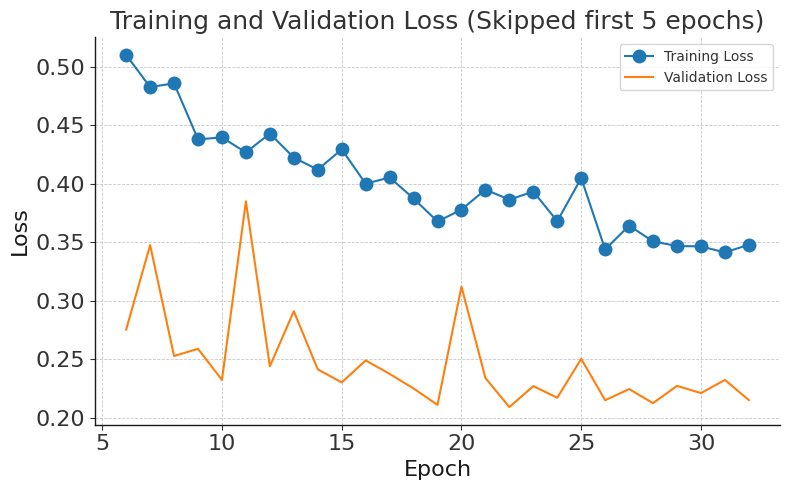

In [25]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the DANN model...")
    print('Model parameters:')
    for key, value in args.items():
        if key == 'module':
            print(f"{key}: DANNNetwork")
        else:
            print(f"{key}: {value}")
    print(f"dan_lambda: {DAN_LAMBDA}")
    custom_nn.fit(dataset, None)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"dann_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"dann_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump({**args, 'dan_lambda': DAN_LAMBDA}, f)

else:
    # Load model and set to CPU
    model_filename = "dann_model_2025-08-19_2nd_try_4_glaciers_50%_lamba0_05_mean_domainloss_even_domainloss_only_Fr_val.pt"  # Replace if needed
    loaded_model = CustomDANNRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

In [17]:
# Load model and set to CPU
model_filename = "dann_model_2025-08-24_5-10%_lamba0_05_mean_domainloss_even_domainloss_only_FR_val_50_50epochsplit.pt"  # Replace if needed
loaded_model = CustomDANNRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Load model and make predictions:

In [18]:
# Create features and metadata
# IMPORTANT: ensure 'DOMAIN' is NOT part of feature_columns (keep it in cfg.metaData)
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

In [19]:
# Summary statistics by glacier for detailed analysis
print("\nDetailed Performance Summary by Glacier:")
glacier_stats = grouped_ids.groupby('GLACIER').agg({
    'target': ['count', 'mean', 'std'],
    'pred': ['mean', 'std']
}).round(4)

# Calculate RMSE and MAE per glacier
glacier_rmse = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.sqrt(np.mean((x['target'] - x['pred'])**2))
).round(4)

glacier_mae = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.mean(np.abs(x['target'] - x['pred']))
).round(4)

glacier_r2 = grouped_ids.groupby('GLACIER').apply(
    lambda x: 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2)
).round(4)

glacier_rho = grouped_ids.groupby('GLACIER').apply(
    lambda x: x['target'].corr(x['pred'])
).round(4)

# Combine all metrics
performance_summary = pd.DataFrame({
    'N_samples': glacier_stats[('target', 'count')],
    'RMSE': glacier_rmse,
    'MAE': glacier_mae,
    'R²': glacier_r2,
    'Pearson': glacier_rho,
    'Target_mean': glacier_stats[('target', 'mean')],
    'Target_std': glacier_stats[('target', 'std')]
}).sort_values('RMSE')

print("Performance by glacier (sorted by RMSE):")
display(performance_summary)


Detailed Performance Summary by Glacier:
Performance by glacier (sorted by RMSE):


,N_samples,RMSE,MAE,R²,Pearson,Target_mean,Target_std
GLACIER,,,,,,,
FR4N01146D09+E06 Gebroulaz,1285,0.6597,0.4907,0.8628,0.9318,-0.3350,1.7820
FR4N01162B09+154D03 de Saint Sorlin,2163,0.7335,0.5407,0.8338,0.9330,-0.4864,1.7997
FR4N01235A08 dArgentiere,2513,0.9035,0.6895,0.8437,0.9240,-0.8150,2.2854
FR4N01236A01 Mer de Glace/Geant,1185,0.9587,0.7092,0.9360,0.9727,-2.0811,3.7912
FR4N01083B21 Blanc,267,2.1455,1.9797,-0.8032,0.8155,-0.8005,1.6007


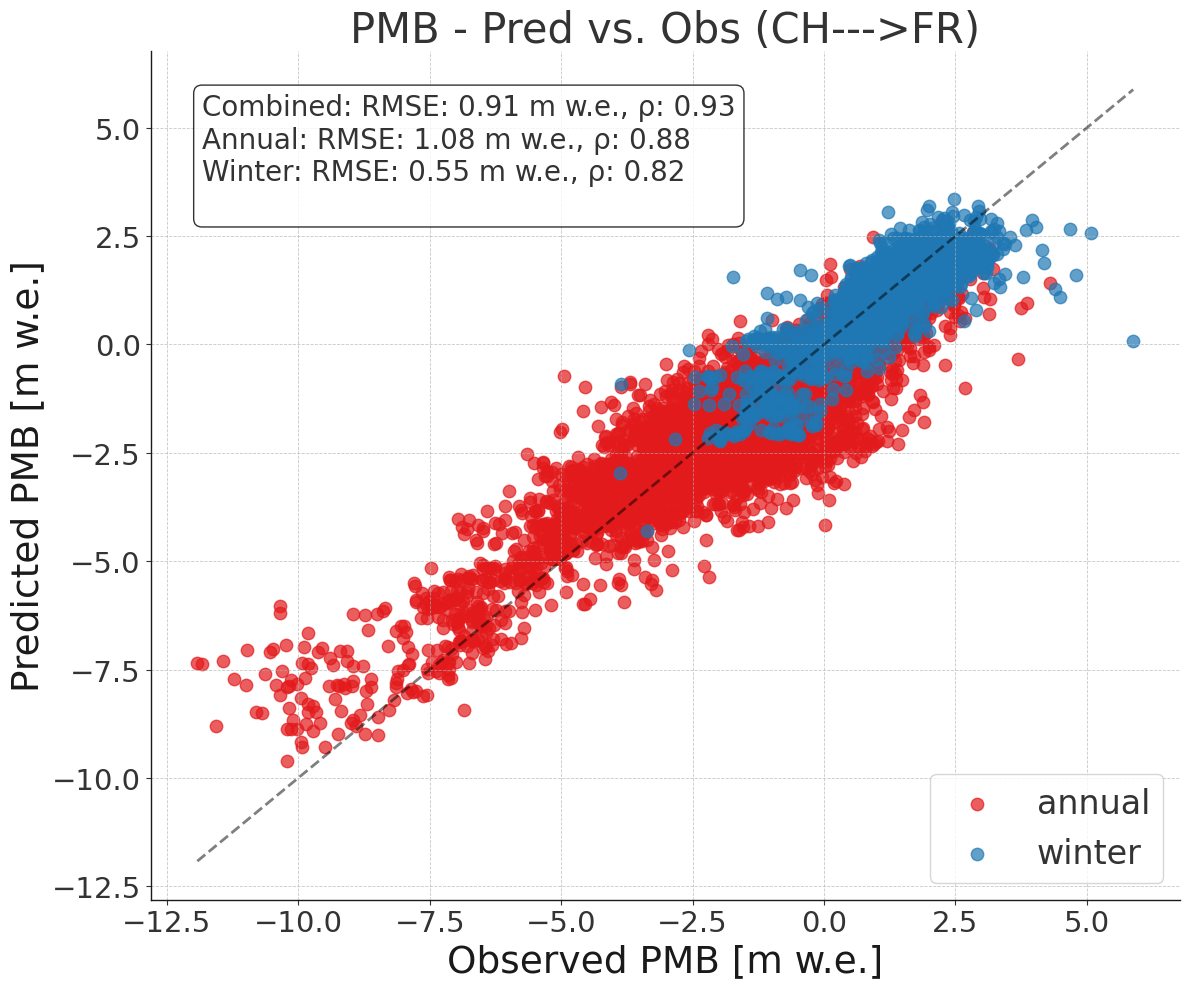

In [20]:
PlotPredictionsCombined_NN(grouped_ids, region_name='CH--->FR', include_summer=False)

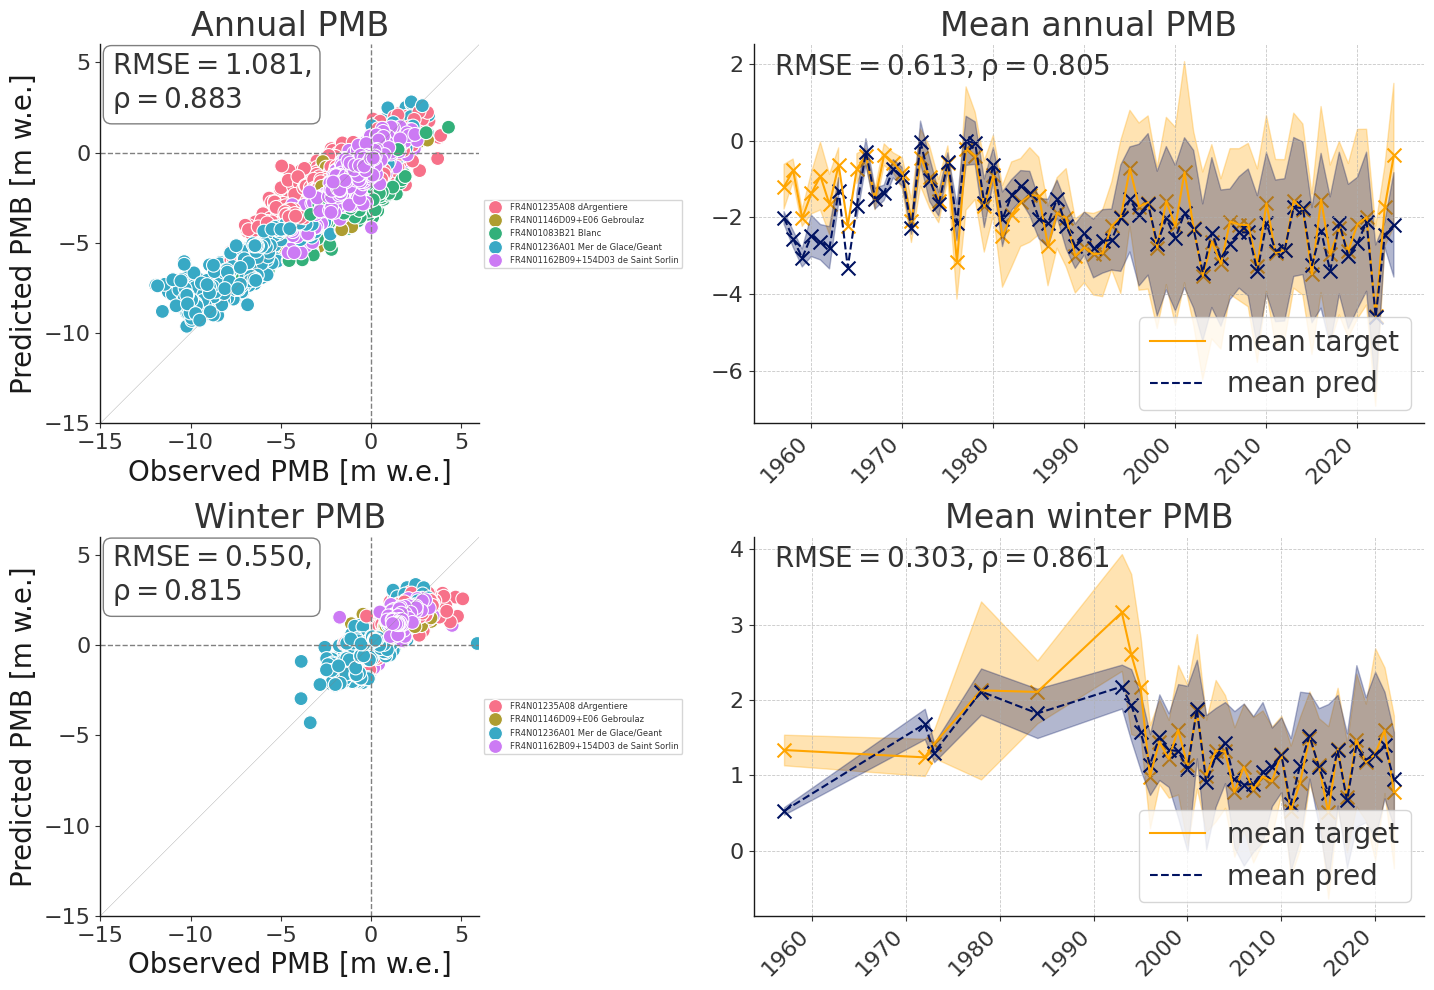

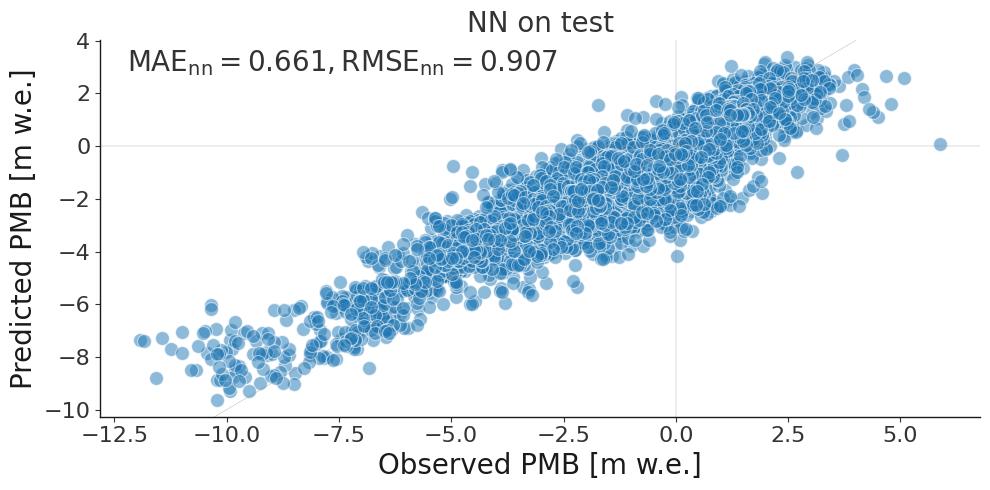

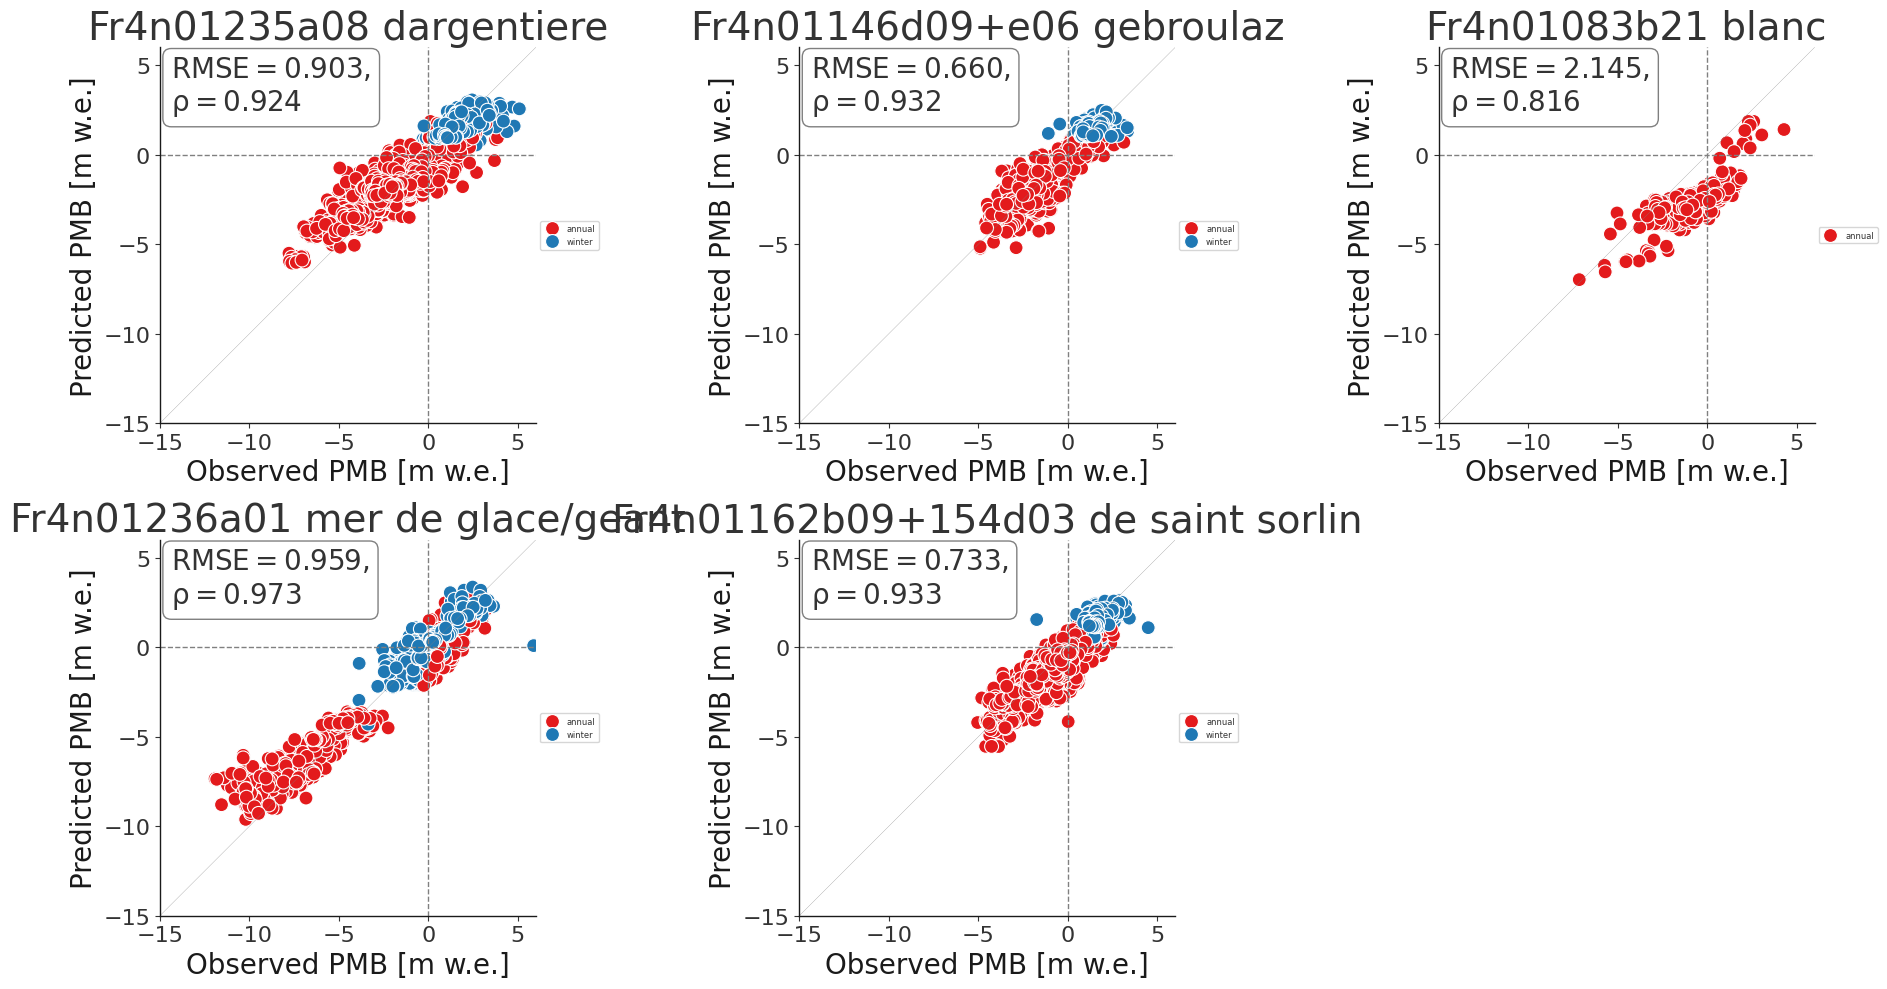

In [21]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))